In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from frugal_flows.causal_flows import get_independent_quantiles, train_frugal_flow

from frugal_flows.bijections import UnivariateNormalCDF

In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
data_path = './data/'

df = pd.read_csv(data_path + 'data_xdyc.csv')
# cols = [i for i in df.columns if i not in ['Z1', 'Z2']]
# df = df[cols].copy()

In [4]:
df.groupby('X').mean()

,Y,Z1,Z2
X,,,
0.0,1.058090,-0.022442,-0.053232
1.0,1.981316,0.004269,0.018220


Normalise for the treatment effect

In [5]:
df['yminx'] = df['Y'] - df['X']

The correlation between the outcomes corresponds with the true correlation matrix:
```
CORRELATION_MATRIX = np.array([
    [1., 0.8, 0.6],
    [0.8, 1., 0.4],
    [0.6, 0.4, 1.]
])
```

In [6]:
df[['Z1', 'Z2', 'yminx']].corr()

,Z1,Z2,yminx
Z1,1.000000,0.793252,0.586831
Z2,0.793252,1.000000,0.368645
yminx,0.586831,0.368645,1.000000


In [7]:
vmapped_normal_cdf = jax.vmap(UnivariateNormalCDF(ate=0., const=0., scale=1.).transform)
u_z1 = vmapped_normal_cdf(df['Z1'].values)
u_z2 = vmapped_normal_cdf(df['Z2'].values)

In [8]:
res = get_independent_quantiles(key = jr.PRNGKey(78),
                                z_cont=jnp.array(df[['Z1', 'Z2']].values),
                                learning_rate=1e-3,
                                max_epochs = 70,
                                max_patience=10,
                                return_z_cont_flow = True,
                             )

 26%|██████████████████████████▍                                                                            | 18/70 [00:03<00:09,  5.41it/s, train=2.767815249169283, val=2.8190261996272468 (Max patience reached)]


In [9]:
res['u_z_cont']

Array([[0.46030506, 0.46027634],
       [0.35466612, 0.42634718],
       [0.49429126, 0.72994313],
       ...,
       [0.17807373, 0.20030018],
       [0.91819639, 0.8985232 ],
       [0.12936246, 0.27350152]], dtype=float64)

In [10]:
frugal_flow, losses =  train_frugal_flow(key=jr.PRNGKey(90),
                y=jnp.array(df['Y'].values)[:,None],
                u_z=res['u_z_cont'],
                RQS_knots=8,
                show_progress=True,
                learning_rate=1e-2,
                max_epochs=500,
                max_patience=30,
                batch_size=100,
                condition=jnp.array(df['X'].values)[:,None],
             )

 29%|████████████████████████████▉                                                                       | 145/500 [00:08<00:20, 17.75it/s, train=0.7797700979062322, val=1.0093256797073358 (Max patience reached)]


### Results

In [11]:
frugal_flow.bijection.bijections[-1].bijection.bijections[0].ate

Array(0.95264336, dtype=float64)

In [12]:
frugal_flow.bijection.bijections[-1].bijection.bijections[0].const

Array(1.04778211, dtype=float64)

## Diagnostics

In [13]:
k1, k2 = jr.split(jr.PRNGKey(970), 2)
frugal_flow_samples_0 = frugal_flow.sample(k1, condition=jnp.zeros((1000,1))) #
frugal_flow_samples_1 = frugal_flow.sample(k2, condition=jnp.ones((1000,1))) #

# Inverse std gaussian CDF
frugal_flow_samples_0 = frugal_flow_samples_0.at[:, 1:].set(jax.scipy.special.ndtri(frugal_flow_samples_0[:, 1:]))
frugal_flow_samples_1 = frugal_flow_samples_1.at[:, 1:].set(jax.scipy.special.ndtri(frugal_flow_samples_1[:, 1:]))

### No correlation between $Y$ and $Z_1$ or $Z_2$

In [14]:
jnp.corrcoef(frugal_flow_samples_0.T)

Array([[1.        , 0.0560078 , 0.04654424],
       [0.0560078 , 1.        , 0.77553026],
       [0.04654424, 0.77553026, 1.        ]], dtype=float64)

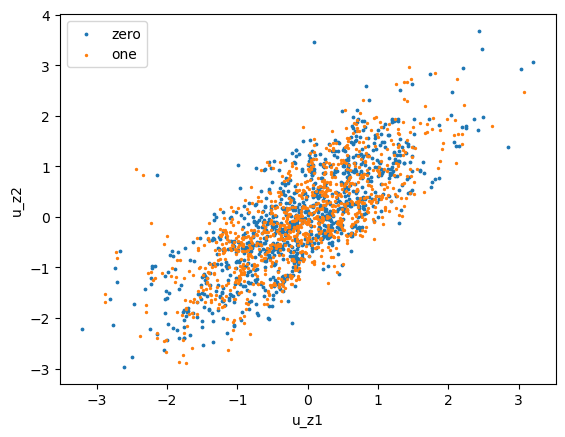

In [15]:
plt.scatter(*frugal_flow_samples_0[:,1:].T, label="zero", s=3)
plt.scatter(*frugal_flow_samples_1[:,1:].T, label="one", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

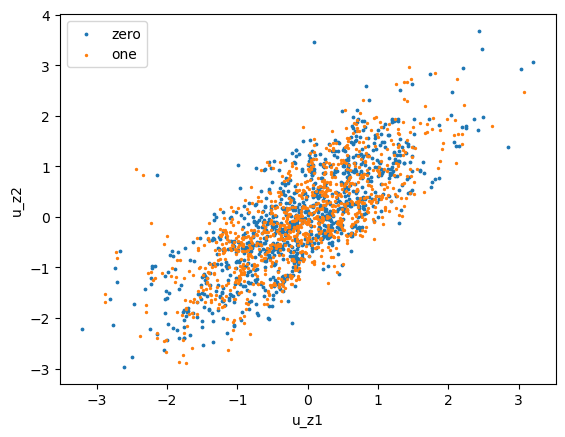

In [16]:
plt.scatter(*frugal_flow_samples_0[:,1:].T, label="zero", s=3)
plt.scatter(*frugal_flow_samples_1[:,1:].T, label="one", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

## X = 0 (Control)

In [17]:
n_samples = 10000
flow_fake_condition = jnp.zeros((n_samples,1))
flow_dim = 3
key = jr.PRNGKey(8)

uni_standard = jr.uniform(key, shape=(n_samples, flow_dim))
uni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[0].tree.transform)(uni_standard)

corruni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[1].transform)(uni_minus1_plus1, flow_fake_condition)
corruni_standard = jax.vmap(frugal_flow.bijection.bijections[2].tree.transform)(corruni_minus1_plus1, flow_fake_condition)
us = corruni_standard

### No correlation between $Y$ and $Z_1$ or $Z_2$

In [18]:
jnp.corrcoef(jax.scipy.special.ndtri(us).T)

Array([[ 1.        , -0.00316581, -0.01097758],
       [-0.00316581,  1.        ,  0.76234023],
       [-0.01097758,  0.76234023,  1.        ]], dtype=float64)

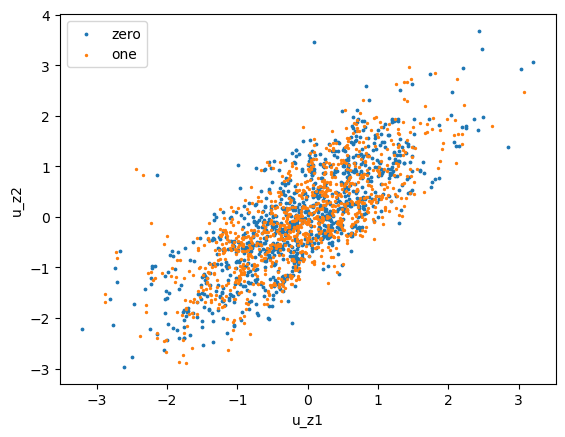

In [19]:
plt.scatter(*frugal_flow_samples_0[:,1:].T, label="zero", s=3)
plt.scatter(*frugal_flow_samples_1[:,1:].T, label="one", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

## X = 1 (Treatment)

In [20]:
n_samples = 10000
flow_fake_condition = jnp.ones((n_samples,1))
flow_dim = 3
key = jr.PRNGKey(7)

uni_standard = jr.uniform(key, shape=(n_samples, flow_dim))
uni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[0].tree.transform)(uni_standard)

corruni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[1].transform)(uni_minus1_plus1, flow_fake_condition)
corruni_standard = jax.vmap(frugal_flow.bijection.bijections[2].tree.transform)(corruni_minus1_plus1, flow_fake_condition)
us = corruni_standard

### No correlation between $Y$ and $Z_1$ or $Z_2$

In [21]:
jnp.corrcoef(jax.scipy.special.ndtri(us).T)

Array([[ 1.        , -0.00905843,  0.00686587],
       [-0.00905843,  1.        ,  0.76831844],
       [ 0.00686587,  0.76831844,  1.        ]], dtype=float64)

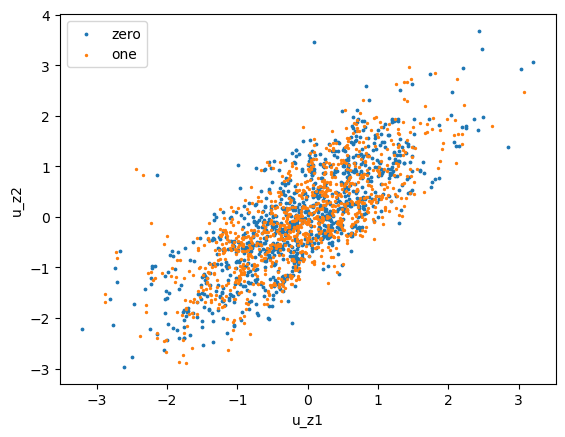

In [22]:
plt.scatter(*frugal_flow_samples_0[:,1:].T, label="zero", s=3)
plt.scatter(*frugal_flow_samples_1[:,1:].T, label="one", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()